In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import different modules for using with the notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import HTML
from IPython.display import display
from IPython.display import Image

from sklearn.linear_model import LogisticRegression as logis
from sklearn.metrics import confusion_matrix


# -------------------------------
#    Manual Prep
# -------------------------------

from sklearn import linear_model, datasets
import itertools
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Gustav's Functions

In [3]:
#NaiveClassifier

import numpy as np
import math

class NaiveClassifier: # Accepts Row data

    def __init__(self): # constructor with implicit attributes (self.thing)
        self.__N = None # number of observations
        self.__d = None # number of dimensions in each observation
        self.__k = None # number of classes
        self.__classes = None # the list of class elements
        self.__class_Ns = None # the list of class counts
        self.__means = None 
        self.__variances = None
        self.__softmax_args = None # the softmax arguments a that are using in the softmax function

        # the variances are vectors of the diagomal elements on sigmas  

    def fit(self, X, y): # Accepts row data

        X = X.T # converts the row data to column data
        # X contains the observations as [x1, x2, ... xN]
        #       y contains the labels as [y1, y2, ... yN]
        self.__N = X.shape[1]  # layer1 is the columns (column data)
        self.__d = X.shape[0]  # layer0 is the rows
        self.__classes = list(set(y))
        self.__k = len(self.__classes) #number of classes = number of unique entries in y
        self.__calculate_means_and_variances(X, y)

    def predict(self, X): # Accepts row data
        # X contains test observations as [x1, x2, ... xQ]
        X = X.T # converts the row data to column data
        predict_N = X.shape[1]
        self.__softmax_args = np.zeros((self.__k, predict_N))
        labels = [0 for p in range(0, predict_N)]
        #x[p] is element p in X, and gets assigned a label[p]
        for p in range(0, predict_N):
            x = X[:,p].astype(np.float32)
            #initialise softmax parameters
            A = [0. for m in range(0, self.__k)]
            B = [0. for m in range(0, self.__k)]
            for m in range(0, self.__k):
                # A[m] = sum(0, l){ -0.5 * ln(2pi * var[l,m]) -1/(2 * var[l, m]) * (x[l, p] - mean[l, m])^2}
                for l in range(0, self.__d):
                    A[m] -= 0.5 * math.log(2 * math.pi * self.__variances[l, m])
                    A[m] -= (1/float(2 * (self.__variances[l, m]))) * ((x[l] - self.__means[l, m]) ** 2)
                # B[m] = ln(class_Ns[m]/N)
                B[m] = math.log(self.__class_Ns[m]/float(self.__N))
                # softmax_args[m] = A[m] + B[m]
                self.__softmax_args[m, p] = A[m] + B[m]
            # labels[p] = index_max{ a[p] } 
            # This is a simplified form of the argmax(softmax) that gives the same result
            labels[p] = self.__index_max(self.__softmax_args[:,p], self.__k)
            
        return np.array(labels)


        
    def __calculate_means_and_variances(self, X, y):

        # initialise all the variable shapes
        self.__class_Ns = [0. for n in range(0, self.__k)]        # contains [N1, N2, ... Nk]
        self.__means = np.zeros((self.__d, self.__k))            # contains [mean1, mean2, ... meank]
        self.__variances = np.zeros((self.__d, self.__k))        # contains [var1, var2, ... vark]

        # means[n] = scaled sum of elements xn in X, with associated label yn
        for m in range(0, self.__k):
            for n in range(0, self.__N):
                if y[n] == m:
                    x = X[:, n].astype(np.float32) # a valid data element x

                    self.__class_Ns[m] += 1
                    
                    for l in range(0, self.__d):
                        self.__means[l, m] += x[l]

        # normalises the mean vectors
        for m in range(0, self.__k):
            for l in range(0, self.__d):
                self.__means[l, m] /= self.__class_Ns[m]

        
        # variances[n] = the elements on the diagonal of sigmas[n]
        for m in range(0, self.__k):
            for n in range(0, self.__N):
                if y[n] == m:
                    cx = X[:, n].astype(np.float32)

                    for l in range(0, self.__d):
                        cx[l] -= self.__means[l,m]

                        self.__variances[l,m] += cx[l] ** 2


            self.__variances[:,m] /= float(self.__class_Ns[m])
            

        # This method of getting the covariance first and then the variances is unneccessary,
        # but its easier for me to implement

    def __index_max(self, arg, length):
        index_of_max = 0;
        maximum = arg[0]

        for m in range(0, length):
            if arg[m] > maximum:
                maximum = arg[m]
                index_of_max = m

        return index_of_max


    # Accessor methods to read private variables
    def get_N(self):
        return self.__N

    def get_d(self):
        return self.__d

    def get_k(self):
        return self.__k

    def get_classes(self):
        return self.__classes

    def get_class_Ns(self):
        return self.__class_Ns

    def get_means(self):
        return self.__means

    def get_variances(self):
        return self.__variances

    def get_softmax_args(self):
        return self.__softmax_args

In [4]:
#FOR LOGISTIC REGRESSION

import numpy as np
import math

class LogisticRegression:

    # constructor with implicit attributes
    def __init__(self, hyper, tolerance):
        self.__hyper = hyper
        self.__tolerance = tolerance

        self.__N = None # number of observations
        self.__d = None # number of dimensions in each observation
        self.__k = None # number of classes
        self.__w = None # the optimized decision boundary parameter

    def fit(self, X, y):

        X = X.T # converts the row data to column data

        # X contains the observations as [x1, x2, ... xN]
        #       y contains the labels as [y1, y2, ... yN]

        self.__N = X.shape[1]  # layer1 is the columns (column data)
        self.__d = X.shape[0]  # layer0 is the rows
        self.__classes = list(set(y))
        self.__k = len(self.__classes) #number of classes = number of unique entries in y

        # modify data with an additional row of ones
        ones_row = [1 for n in range(0, self.__N)]
        X = np.vstack([ones_row, X])

        #initialise w
        w = np.ones((self.__d + 1, 1))

        # measure = mag(w[n + 1] - w[n])/mag(w[n])
        measure = 1000;  # just a large starting value

        # Update Rule: w[n + 1] = w[n] - [H]^(-1) * G(w[n])
        
        # until measure < tolerance
        while measure >= self.__tolerance:
            w_prev = w

            w = w - np.linalg.inv(self.__hessian(X, w)).dot(self.__gradient(X, y, w))
            measure = np.linalg.norm(w - w_prev)/np.linalg.norm(w_prev)

        self.__w = w


    def predict(self, X):
        
        X = X.T # converts the row data to column data

        # X contains the observations as [x1, x2, ... xQ]

        predict_N = X.shape[1]
        labels = [0 for p in range(0, predict_N)]

        # modify data with an additional row of ones
        ones_row = [1 for n in range(0, predict_N)]
        X = np.vstack([ones_row, X])

        for p in range(0, predict_N):

            x = X[:, p][:, np.newaxis].astype(np.float32)
            sig = self.__sigmoid(self.__w, x)

            if sig >= 0.5:
                labels[p] = 1  # no else case needed since the labels are initialised to 0

        return np.array(labels)


    def __hessian(self, X, w):

        #initialise hessian
        hess = 0

        # hess = sum(0, N){ sigmoid * (1 - sigmoid) * outer_x) + (1/hyper) * I }
        for n in range(0, self.__N):

            x = X[:, n][:, np.newaxis].astype(np.float32)
            sig = self.__sigmoid(w, x)
            outer_x = x.dot(x.T)

            hess += sig * (1 - sig) * outer_x + (1/self.__hyper) * np.identity(self.__d + 1)

        return hess

    def __gradient(self, X, y, w):

        #initialise gradient
        grad = 0

        #grad = sum(0, N){ (sigmoid - y[n]) * x }   +   (1/hyper) * w 
        for n in range(0, self.__N):

            x = X[:, n][:, np.newaxis].astype(np.float32)
            sig = self.__sigmoid(w, x)

            grad += (sig - y[n]) * x

        # include the regularisation term  afterwards 
        grad += (1/self.__hyper) * w

        return grad

    def __sigmoid(self, w, x):

        # sigmoid = sigmoid{ w.T.dot(x[n]) }
        arg = w.T.dot(x)
        sigmoid = 1/float(1 + np.exp(-arg))

        return sigmoid


# Generate training data

In [5]:
# Training data - three randomly-generated Gaussian-distributed clouds of points in 2d space
np.random.seed(0)
# Number of points
N = 1000
# Labels for each cluster
y = np.random.randint(low=0, high=2+1, size = N)
# Mean of each cluster
means = np.array([[-1, 1, -1], [-1, 1, 1],])
# Covariance (in X and Y direction) of each cluster
covariances = np.random.random_sample((2, 3)) + 1
# Dimensions of each point
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
               np.random.randn(N)*covariances[1, y] + means[1, y]])

#### Display the data that you generated to find something like the following:

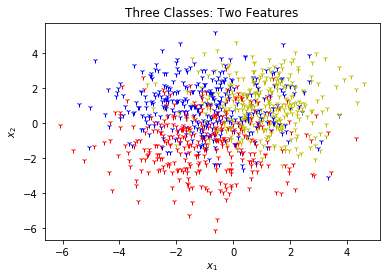

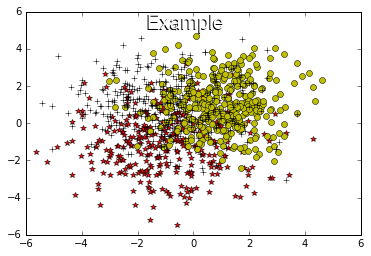

In [6]:
# Plot the data
#print(X.shape[1]) number of all markers
c = np.array(["r","y","b"])#array of characters we want to split into
for k in range(X.shape[1]):#k to 1000
    plt.plot(X[0,k],X[1,k],c[y[k]]+"1")#'1' is for the marker shape
    
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Three Classes: Two Features")
plt.show()

X = X.T

display(Image(filename='./images/wm_dat1.png'))

# Fit the training data to the scikit-learn softmax classifier

The image above shows that there is considerable overlap between the classes. Use your trained classifier to assign all the training data to different classes.

**Print the confusion matrix and also plot it, to get something like the image below:**

In [7]:
import itertools
#just a function to plot the confuision matrix
def plot_confusion_matrix(cm, classes,normalize=True,title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization') 

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


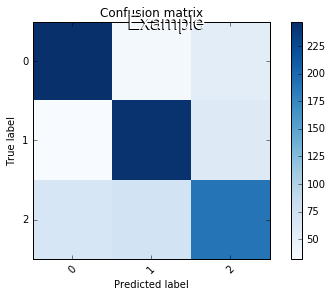

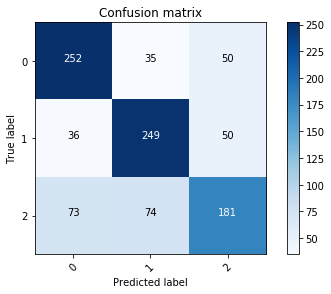

In [8]:
#code for "Fit the training data to the scikit-learn softmax classifier"
c1 = np.array(["0","1","2"])#to match given image
clf = logis()#for multiple dimensions
clf.fit(X, y)#actual fit
y_pred = clf.predict(X)#predict using logis
cm = confusion_matrix(y,y_pred)#make a confusion matrix
#print(cm)
plot_confusion_matrix(cm,c1,False)#false is non-normalised, true/not stated is normalised

display(Image(filename='./images/wm_confusion.png'))

**Now plot the different classes as predicted by your system. You should get something like:** 

**Can you tell from the graph that this is a *linear* classifier?**

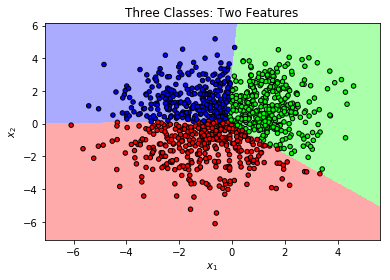

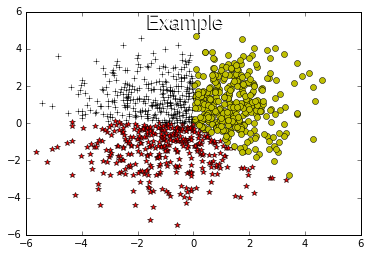

In [9]:
# SETUP
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])# ravel()->Return a contiguous flattened array.

# COLORMESH PLOT
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)#<--------------This will show you the color boundaries

# SCATTER PLOT
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=cmap_bold,edgecolor='k', s=20)
plt.axis('tight')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Three Classes: Two Features")
plt.show()

# SHAPE TEST -- FOR DEBUGGING PURPOSES ONLY
# print(X.shape)
# print(y_pred.shape)
# print(xx.shape)
# print(yy.shape)

display(Image(filename='./images/wm_dat2.png'))

# Implement a Naive Bayes Classifier

Implement your own Naive Bayes Classifier (from first principles). Train it using the exact same data you used for the previous question (write it in a seperate python file which you can import into the notebook). Implement it in a generic way, i.e. it should be able to work on $d$ dimensional data and it should not be limited to a certain amount of classes.

Use your trained classifier to assign all the training data to different classes.

**Print the confusion matrix and also plot it, to get something like the image below:**

variances:
[[2.67191435 1.61986915 2.79945325]
 [2.48728109 1.85423747 2.00444396]]
Normalized confusion matrix


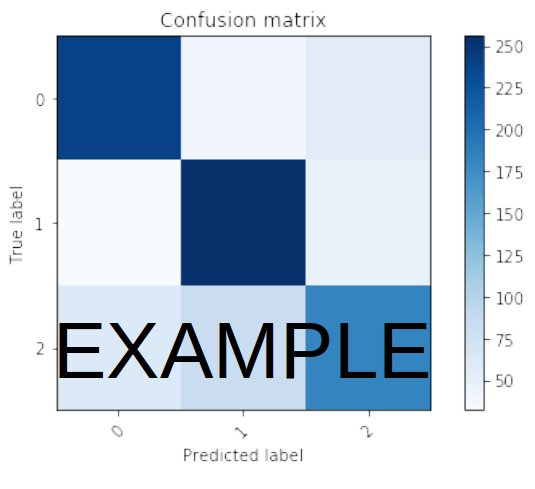

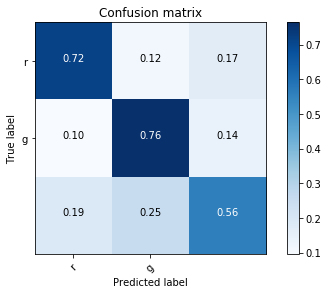

In [10]:
clf = NaiveClassifier()
clf.fit(X,y)

#Use your trained classifier to assign all the training data to different classes.
y_predict = clf.predict(X)
print("variances:")
print(clf.get_variances())

c = np.array(["r","g"]) # use ["r", "g", "b"] for 3 classes
cm = confusion_matrix(y,y_predict)
plot_confusion_matrix(cm,c)

display(Image(filename='./images/conf_mat_bayes.jpg'))

**Now plot the different classes as predicted by your system. You should get something like:**

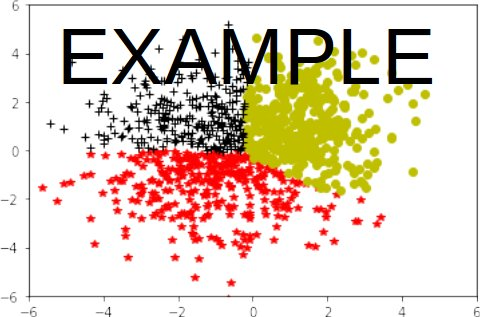

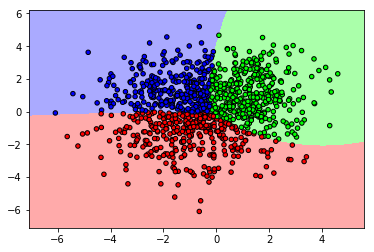

In [11]:
# SETUP
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# COLORMESH PLOT --- TAKES SUPER LONG WITH MY CODE
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# SCATTER PLOT
plt.scatter(X[:, 0], X[:, 1], c=y_predict, cmap=cmap_bold,
          edgecolor='k', s=20)
plt.axis('tight')

# SHAPE TEST -- FOR DEBUGGING PURPOSES ONLY
# print(X.shape)
# print(y_predict.shape)
# print(xx.shape)
# print(yy.shape)

display(Image(filename='./images/predict_bayes.jpg'))

# Implement a Logistic Regression Classifier

Implement your own Logistic Regression classifier (from first principles). It should be generic and be able to work on $d$ dimensional data (and two classes). Please make your implementation as modular as possible, having a seperate function for the Hessian and the gradient vector (write it in a seperate python file which you can import into the notebook). A regularization term based on a Gaussian prior (with zero mean and covariance matrix $\lambda\mathbf{I}$) must be included.  Optionally, a bias term also needs to be incorporated into your classifier - this can be implemented by augmenting the training dataset with an additional all-one feature.

**Now train your classifier using the following data.**

In [12]:
# Training data - two randomly-generated Gaussian-distributed clouds of points in 2d space
np.random.seed(0)
# Number of points
N = 1000
# Labels for each cluster
y = np.random.randint(low=0, high=2, size = N)
# Mean of each cluster
means = np.array([[-1, 1], [-1, 1],])
# Covariance (in X and Y direction) of each cluster
covariances = np.random.random_sample((2, 2)) + 1
# Dimensions of each point
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
               np.random.randn(N)*covariances[1, y] + means[1, y]])

X = X.T # converts the data to row data, like all the other data

# print(y.shape)
# print(X.shape)

Use your trained classifier to assign all the training data to different classes.

**Print the confusion matrix and also plot it, to get something like the image below:** 

Normalized confusion matrix


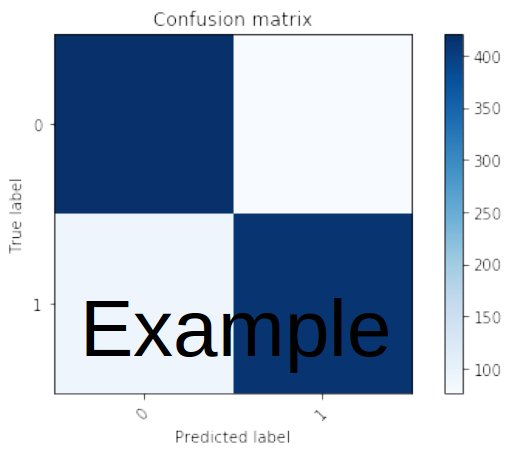

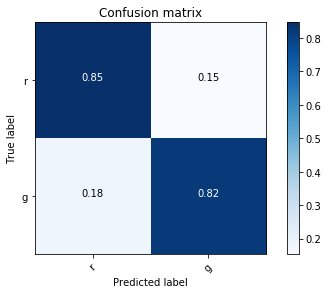

In [13]:
hyper = 2
tolerance = 1e-5
clf = LogisticRegression(hyper, tolerance)
#Use your classifier to fit the data.
clf.fit(X, y)
#Use your trained classifier to assign all the training data to different classes.
y_predict = clf.predict(X)
c = np.array(["r","g"]) # use ["r", "g", "b"] for 3 classes
cm = confusion_matrix(y,y_predict)
plot_confusion_matrix(cm,c)

display(Image(filename='./images/conf_mat_logreg.jpg'))

**Now plot the different classes as predicted by your system. Add your decision boundary to the same plot. You should get something like:**

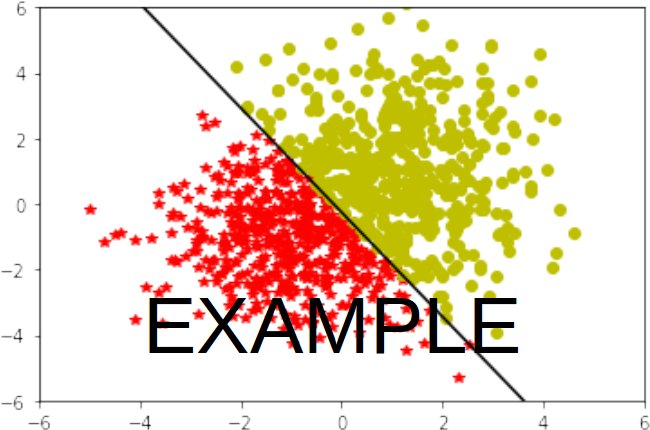

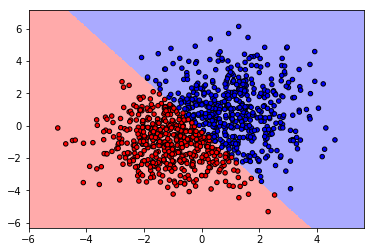

In [14]:
# SETUP
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# COLORMESH PLOT
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# SCATTER PLOT
plt.scatter(X[:, 0], X[:, 1], c=y_predict, cmap=cmap_bold,
          edgecolor='k', s=20)
plt.axis('tight')

# SHAPE TEST -- FOR DEBUGGING PURPOSES ONLY
# print(X.shape)
# print(y_predict.shape)
# print(xx.shape)
# print(yy.shape)

display(Image(filename='./images/predict_logreg.jpg'))

** Before continuing in the notebook, you will need to install the `lasagne` Python module with "pip3 install --user lasagne" **

# Now classify the MNIST digits 

The MNIST database provided in the assignment resources consists of low-resolution (28x28) grayscale images of handwritten digits ($0,1,2,3,4,5,6,7,8,9$). First, you read in a set of training digits and display them interactively to get an idea what they look like. Afterwards, you build and train a softmax classifier using scitkit-image and scikit-learn. You will then classify the digits in the test set and display the results. Finally, you will display the weights as images.

First load the dataset - for more information about the dataset, see http://yann.lecun.com/exdb/mnist/.

In [15]:
from mnist import load_dataset
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset()

## Display the test digits interactively.

In [16]:
from ipywidgets import interact
def show_digits(k=0):
    """
    Show the first 1000 digits in the training set
    """
    
    plt.imshow(X_train[k][0], cmap=cm.binary)   
    
    plt.show()
    
#w = interact(show_digits, k =(0, 1000)) 


## Train the softmax classifier

**Using the training set, build a softmax classifier. Use this classifier to classify the digits in the training set and the test set separately. Print the confusion matrix and also display it as an image for each case to get something like:**

(10000, 1, 28, 28)
Normalized confusion matrix


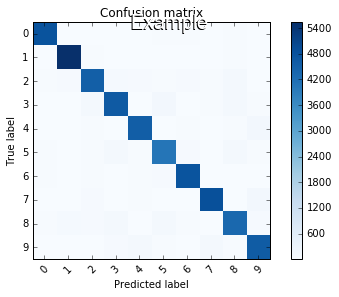

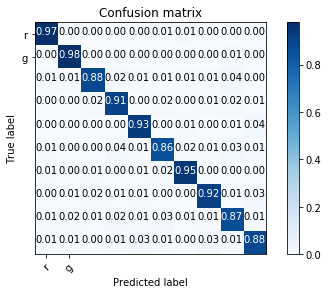

In [17]:
X = X_train[:,0].reshape(50000, -1)
y = y_train

clf = logis(C=1e5)
clf.fit(X, y)

# TRAIN DATA PREDICTIONS
#y_predict = clf.predict(X)

#c = np.array(["r","g"]) # use ["r", "g", "b"] for 3 classes
#cm = confusion_matrix(y,y_predict)
#plot_confusion_matrix(cm,c)

print(X_test.shape)

X = X_test[:,0].reshape(10000, -1)
y = y_test

# TEST DATA PREDICTIONS
y_predict = clf.predict(X)

c = np.array(["r","g"]) # use ["r", "g", "b"] for 3 classes
cm = confusion_matrix(y,y_predict)
plot_confusion_matrix(cm,c)


display(Image(filename='./images/wm_confusion2.png'))

### Accuracy

**Calculate the accuracy of your system as a fraction of the correctly classified digits. You should get something like 0.9254. use - `logis(C=1e5, solver='lbfgs', multi_class='multinomial')`**

Normalized confusion matrix
Accuracy:
0.9845
0.9845


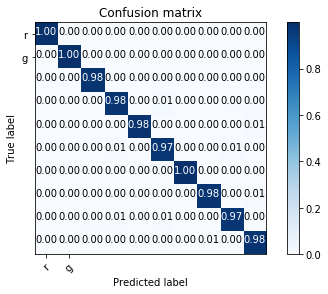

In [18]:
clf = logis(C=1e5, solver='lbfgs', multi_class='multinomial')

clf.fit(X, y)
y_predict = clf.predict(X)

c = np.array(["r","g"]) # use ["r", "g", "b"] for 3 classes
cm = confusion_matrix(y,y_predict)
plot_confusion_matrix(cm,c)

correct = 0

for n in range(0, 10000):
    if y[n] == y_predict[n]:
        correct += 1
    
print("Accuracy:")
accuracy = correct/10000
print(accuracy)

accuracy = clf.score(X, y, sample_weight=None)
print(accuracy)

## Extracting the weights and display as images.

**Extract the weights of the softmax classifier and display them as images. Each set of weights should correspond to a specific digit**. 

**As an example the weight image associated with the 0 digit should look similar to this:**

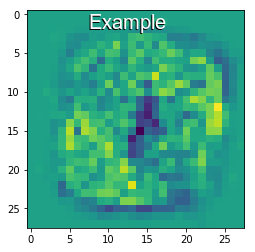

In [19]:
display(Image(filename='./wm_softmax_mnist_weights/wm_0.png'))

In [20]:
# plot weights vs the pixel position

coef = clf.coef_.copy()

def show_weights(n=0):
    plt.figure(figsize=(10, 5))
    scale = np.abs(coef).max()

    #l2_plot = plt.subplot(2, 5, n + 1)

    
    plt.imshow(coef[n].reshape(28, 28), interpolation='nearest',
                   cmap='viridis', vmin=-scale, vmax=scale)   
    
w = interact(show_weights, n = (0, 9))

interactive(children=(IntSlider(value=0, description='n', max=9), Output()), _dom_classes=('widget-interact',)…

## Further investigation

Fit the softmax classifier for different values of the regularization parameter - we recommend values evenly spaced on the log scale - and show the corresponding weight images for some digit as the parameter changes.  Explain the changes in the weight images observed. Moreover, plot the accuracy of your classifier as a function of the regularization parameter. Use this plot to expand on your answer.

In [21]:
# #--------------------------------------------------------
# #                Your Work Here
# #--------------------------------------------------------
# accuracy = [0. for p in range(0, 10)]
# lambdaa = [0. for p in range(0, 10)]

# for p in range(0, 10):
#     X = X_train[:,0].reshape(50000, -1)
#     y = y_train
    
#     lambdaa[p] = 1 * 10 ** p
#     clf = logis(C=lambdaa[p])
#     clf.fit(X, y)

#     X = X_train[:,0].reshape(X_train.shape[0], -1)
#     y = y_train

#     y_predict = clf.predict(X)
    
#     accuracy[p] = clf.score(X, y, sample_weight=None)

# for p in range(0, 10):
#     print("Accuracy for lamda {} is: {}".format(lambdaa[p], accuracy[p]))

In [22]:
# It can be seen that Choosing C = 1 works much better than C = 1e5 ... 